In [54]:
# !pip install nltk    
# !pip install emoji        
# !pip install autocorrec\t    
# !pip install xgboost
# !pip install -U spacy

In [2]:
# nltk.download('all-corpora')
# nltk.download('punkt')  # for using word_tokenizer
# nltk.download('wordnet')  # for using Lemmatizer
# nltk.download('averaged_perceptron_tagger') # for language processing i.e tagging words with their parts of speech (POS)
# !python -m spacy download en_core_web_lg

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import spacy
import nltk
import re   # regular expression
import string
import multiprocessing
from multiprocessing import Pool
import scipy.sparse as sp
import joblib
import emoji
from autocorrect import Speller   # for correcting spelling
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize    # for tokenizing string into words
from nltk.stem import WordNetLemmatizer    # for lemmatizing words
from nltk.tag import pos_tag # for tagging words with their parts of speech (POS)

2022-09-26 19:12:28.807517: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import sklearn

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest,chi2, mutual_info_classif
from sklearn.decomposition import PCA

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost
from xgboost import XGBClassifier

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

In [8]:
df_train = pd.read_csv('data/project_training_data_with_class_labels.csv',dtype=str,delimiter=',',quoting=3)

In [9]:
df_train.shape

(808661, 4)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808661 entries, 0 to 808660
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ID               808661 non-null  object
 1   Comments         808623 non-null  object
 2   Parent Comments  808661 non-null  object
 3    Class Labels    808661 non-null  object
dtypes: object(4)
memory usage: 24.7+ MB


In [11]:
# to check for null value
df_train.isna().sum()

ID                  0
Comments           38
Parent Comments     0
 Class Labels       0
dtype: int64

In [12]:
df_train.columns

Index(['ID', 'Comments', 'Parent Comments', ' Class Labels '], dtype='object')

In [13]:
df_train.rename(columns={' Class Labels ' : 'Class Labels'},inplace=True) # changing col name
df_train.columns

Index(['ID', 'Comments', 'Parent Comments', 'Class Labels'], dtype='object')

In [15]:
df_train= df_train.replace(to_replace = np.nan, value = '', regex = True)

In [16]:
# to check for null value
df_train.isna().sum()

ID                 0
Comments           0
Parent Comments    0
Class Labels       0
dtype: int64

In [17]:
# we are combining Parent Comment and Comment cols. into one cols.
# Inserting the column before Class Labels col.
df_train.insert(loc = 3,
        column = 'Text',
        value = df_train['Parent Comments'] + " " +df_train['Comments'])

df_train.head()

,ID,Comments,Parent Comments,Text,Class Labels
0,ocxtitan,Central Illinois,Jesus; where do you live?,Jesus; where do you live? Central Illinois,non-sarcastic
1,LeChuckly,To think - CNN used to be the acronym synonymo...,Even The CNN Staff Is Sick Of The Wall-To-Wall...,Even The CNN Staff Is Sick Of The Wall-To-Wall...,non-sarcastic
2,throwitskrub8,But then again; you have to consider that all ...,agree to that part.It can also mean that gujra...,agree to that part.It can also mean that gujra...,non-sarcastic
3,fresherthanyouuu,ughhhhh,If a guy told you he doesn't use social media ...,If a guy told you he doesn't use social media ...,non-sarcastic
4,_kushagra,I should've put the,No; it's just a programming bug. After all; th...,No; it's just a programming bug. After all; th...,sarcastic


In [18]:
df_train.shape

(808661, 5)

In [20]:
# to check for null value
df_train.isnull().sum()

ID                 0
Comments           0
Parent Comments    0
Text               0
Class Labels       0
dtype: int64

In [22]:
# # to check for null value
df_train.isnull().sum()

Since here there is issue with the format of some rows. So we are manually correcting them.

In [23]:
df_test = pd.read_csv('data/project_test_data.csv',dtype=str,delimiter=',',quoting=3)
df_test.head()

,ID,Comments,Parent Comments
0,theyoungthaddeus,"No one ""needs"" an assault foam dart blaster",Your son has to register those at the county j...
1,Just_an_asian_here,Cause all attractive women are uninteresting a...,Likely due to creative and interesting content.
2,Foxprowl,Poser.,Jon Stewart is going to HBO
3,kd7rzv,Won't be long and Anet will start banning peop...,This post looks like bullshit market manipulat...
4,Ellefied,There goes my hope that Kubo does a Kojima as ...,Plus the Japanese typically do not talk shit w...


In [24]:
df_test.shape

(202166, 3)

In [25]:
# to check for null value
df_test.isnull().sum()

ID                   0
Comments            15
Parent Comments      0
dtype: int64

In [26]:
df_test= df_test.replace(to_replace = np.nan, value = '', regex = True)

In [27]:
# to check for null value
df_test.isnull().sum()

ID                  0
Comments            0
Parent Comments     0
dtype: int64

In [28]:
df_test.columns

Index(['ID', 'Comments', 'Parent Comments '], dtype='object')

In [29]:
df_test.rename(columns={'Parent Comments ': 'Parent Comments'},inplace = True)

In [30]:
df_test.columns

Index(['ID', 'Comments', 'Parent Comments'], dtype='object')

In [31]:
# we are combining Parent Comment and Comment cols. into one cols.
df_test['Text'] = df_test['Parent Comments'] + " " +df_test['Comments']
df_test.head()

,ID,Comments,Parent Comments,Text
0,theyoungthaddeus,"No one ""needs"" an assault foam dart blaster",Your son has to register those at the county j...,Your son has to register those at the county j...
1,Just_an_asian_here,Cause all attractive women are uninteresting a...,Likely due to creative and interesting content.,Likely due to creative and interesting content...
2,Foxprowl,Poser.,Jon Stewart is going to HBO,Jon Stewart is going to HBO Poser.
3,kd7rzv,Won't be long and Anet will start banning peop...,This post looks like bullshit market manipulat...,This post looks like bullshit market manipulat...
4,Ellefied,There goes my hope that Kubo does a Kojima as ...,Plus the Japanese typically do not talk shit w...,Plus the Japanese typically do not talk shit w...


<AxesSubplot:>

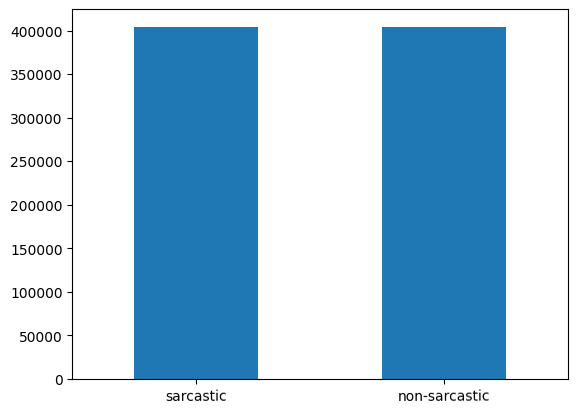

In [32]:
df_train['Class Labels'].value_counts().plot(kind = 'bar',rot = .3)

In [33]:
# english Stopwords
stopwords_list = stopwords.words('english')

In [34]:
# used this dictionary for expanding conracted words. this is taken from Github
CONTRACTIONS = {
    "I'm": "I am",
    "I'm'a": "I am about to",
    "I'm'o": "I am going to",
    "I've": "I have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'd": "I would",
    "I'd've": "I would have",
    "Whatcha": "What are you",
    "amn't": "am not",
    "ain't": "are not",
    "aren't": "are not",
    "'cause": "because",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "daren't": "dare not",
    "daresn't": "dare not",
    "dasn't": "dare not",
    "didn't": "did not",
    "didn’t": "did not",
    "don't": "do not",
    "don’t": "do not",
    "doesn't": "does not",
    "e'er": "ever",
    "everyone's": "everyone is",
    "finna": "fixing to",
    "gimme": "give me",
    "gon't": "go not",
    "gonna": "going to",
    "gotta": "got to",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he've": "he have",
    "he's": "he is",
    "he'll": "he will",
    "he'll've": "he will have",
    "he'd": "he would",
    "he'd've": "he would have",
    "here's": "here is",
    "how're": "how are",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how's": "how is",
    "how'll": "how will",
    "isn't": "is not",
    "it's": "it is",
    "'tis": "it is",
    "'twas": "it was",
    "it'll": "it will",
    "it'll've": "it will have",
    "it'd": "it would",
    "it'd've": "it would have",
    "kinda": "kind of",
    "let's": "let us",
    "luv": "love",
    "ma'am": "madam",
    "may've": "may have",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "ne'er": "never",
    "o'": "of",
    "o'clock": "of the clock",
    "ol'": "old",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "o'er": "over",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shalln't": "shall not",
    "shan't've": "shall not have",
    "she's": "she is",
    "she'll": "she will",
    "she'd": "she would",
    "she'd've": "she would have",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "somebody's": "somebody is",
    "someone's": "someone is",
    "something's": "something is",
    "sux": "sucks",
    "that're": "that are",
    "that's": "that is",
    "that'll": "that will",
    "that'd": "that would",
    "that'd've": "that would have",
    "em": "them",
    "there're": "there are",
    "there's": "there is",
    "there'll": "there will",
    "there'd": "there would",
    "there'd've": "there would have",
    "these're": "these are",
    "they're": "they are",
    "they've": "they have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they'd": "they would",
    "they'd've": "they would have",
    "this's": "this is",
    "those're": "those are",
    "to've": "to have",
    "wanna": "want to",
    "wasn't": "was not",
    "we're": "we are",
    "we've": "we have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we'd": "we would",
    "we'd've": "we would have",
    "weren't": "were not",
    "what're": "what are",
    "what'd": "what did",
    "what've": "what have",
    "what's": "what is",
    "what'll": "what will",
    "what'll've": "what will have",
    "when've": "when have",
    "when's": "when is",
    "where're": "where are",
    "where'd": "where did",
    "where've": "where have",
    "where's": "where is",
    "which's": "which is",
    "who're": "who are",
    "who've": "who have",
    "who's": "who is",
    "who'll": "who will",
    "who'll've": "who will have",
    "who'd": "who would",
    "who'd've": "who would have",
    "why're": "why are",
    "why'd": "why did",
    "why've": "why have",
    "why's": "why is",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "you're": "you are",
    "you've": "you have",
    "you'll've": "you shall have",
    "you'll": "you will",
    "you'd": "you would",
    "you'd've": "you would have"
 }

In [35]:
#I created a dictionary for emoticons
EMOTICONS = {
    u":‑)":"Happy",
    u":-))":"Very Happy",
    u":-)))":"Very very Happy",
    u":)":"Happy",
    u":))":"Very Happy",
    u":)))":"Very very Happy",
    u":-]":"Happy",
    u":]":"Happy",
    u":-3":"Happy",
    u":3":"Happy",
    u":->":"Happy",
    u":>":"Happy",
    u"8-)":"Happy",
    u":o)":"Happy",
    u":-}":"Happy",
    u":}":"Happy",
    u":-)":"Happy",
    u":c)":"Happy",
    u":^)":"Happy",
    u"=]":"Happy",
    u"=)":"Happy",
    u":‑D":"Laughing",
    u":D":"Laughing",
    u"8‑D":"Laughing",
    u"8D":"Laughing",
    u"X‑D":"Laughing",
    u"XD":"Laughing",
    u"=D":"Laughing",
    u"=3":"Laughing",
    u"B^D":"Laughing",
    u":-))":"Very happy",
    u"<3":"love",
    u":-(":"sad",
    u":‑(":"sad",
    u":(":"sad",
    u":‑c":"sad",
    u":c":"sad",
    u":‑<":"sad",
    u":<":"sad",
    u":‑[":"sad",
    u":[":"sad",
    u":-||":"sad",
    u">:[":"sad",
    u":{":"sad",
    u":@":"sad",
    u">:(":"sad",
    u":'‑(":"Crying",
    u":'(":"Crying",
    u":'‑)":"Tears of happiness",
    u":')":"Tears of happiness",
    u"D‑':":"sad",
    u"D:<":"sad",
    u"D:":"sad",
    u"D8":"very sad",
    u"D;":"very sad",
    u"D=":"very sad",
    u"DX":"very sad",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Sad",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-*":"Kiss",
    u":*":"Kiss",
    u":X":"Kiss",
    u";‑)":"Wink",
    u";)":"Wink",
    u"*-)":"Wink",
    u"*)":"Wink",
    u";‑]":"Wink",
    u";]":"Wink",
    u";^)":"Wink",
    u":‑,":"Wink",
    u";D":"Wink",
    u":‑P":"fun",
    u":P":"fun",
    u"X‑P":"fun",
    u"XP":"fun",
    u":‑Þ":"fun",
    u":Þ":"fun",
    u":b":"fun",
    u"d:":"fun",
    u"=p":"fun",
    u">:P":"fun",
    u":‑/":"annoyed",
    u":/":"annoyed",
    u":-[.]":"annoyed",
    u">:[(\)]":"annoyed",
    u">:/":"annoyed",
    u":[(\)]":"annoyed",
    u"=/":"annoyed",
    u"=[(\)]":"annoyed",
    u":L":"annoyed",
    u"=L":"annoyed",
    u":S":"annoyed",
    u":‑|":"indecision",
    u":|":"indecision",
    u":$":"Embarrassed",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑)":"Angel",
    u"O:)":"Angel",
    u"0:‑3":"Angel",
    u"0:3":"Angel",
    u"0:‑)":"Angel",
    u"0:)":"Angel",
    u":‑b":"fun",
    u"0;^)":"Angel",
    u">:‑)":"devilish",
    u">:)":"devilish",
    u"}:‑)":"devilish",
    u"}:)":"devilish",
    u"3:‑)":"devilish",
    u"3:)":"devilish",
    u">;)":"devilish",
    u"|;‑)":"Cool",
    u"|‑O":"Bored",
    u":‑J":"Tongue in cheek",
    u"#‑)":"Party all night",
    u"%‑)":"confused",
    u"%)":"confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑|":"silent",
    u"(>_<)":"Troubled",
    u"(>_<)>":"Troubled",
    u"(';')":"Baby",
    u"(^^>``":"Nervous",
    u"(^_^;)":"Troubled",
    u"(-_-;)":"Nervous",
    u"(~_~;) (・.・;)":"Shy",
    u"(-_-)zzz":"Sleeping",
    u"(^_-)":"Wink",
    u"((+_+))":"Confused",
    u"(+o+)":"Confused",
    u"(o|o)":"Ultraman",
    u"^_^":"happy",
    u"(^_^)/":"happy",
    u"(^O^)／":"happy",
    u"(^o^)／":"happy",
    u"(__)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_(._.)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<(_ _)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m(__)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m(__)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m(_ _)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"('_')":"Sad",
    u"(/_;)":"Sad",
    u"(T_T) (;_;)":"Sad",
    u"(;_;":"Sad",
    u"(;_:)":"Sad",
    u"(;O;)":"Sad",
    u"(:_;)":"Sad",
    u"(ToT)":"Sad",
    u";_;":"Sad",
    u";-;":"Sad",
    u";n;":"Sad",
    u";;":"Sad",
    u"Q.Q":"Sad",
    u"T.T":"Sad",
    u"QQ":"Sad",
    u"Q_Q":"Sad",
    u"(-.-)":"Shame",
    u"(-_-)":"Shame",
    u"(一一)":"Shame",
    u"(；一_一)":"Shame",
    u"(=_=)":"Tired",
    u"(=^·^=)":"cat",
    u"(=^··^=)":"cat",
    u"=_^= ":"cat",
    u"(..)":"Looking down",
    u"(._.)":"Looking down",
    u"^m^":"Giggling",
    u"(・・?":"Confusion",
    u"(?_?)":"Confusion",
    u">^_^<":"Normal Laugh",
    u"<^!^>":"Normal Laugh",
    u"^/^":"Normal Laugh",
    u"（*^_^*）" :"Normal Laugh",
    u"(^<^) (^.^)":"Normal Laugh",
    u"(^^)":"Normal Laugh",
    u"(^.^)":"Normal Laugh",
    u"(^_^.)":"Normal Laugh",
    u"(^_^)":"Normal Laugh",
    u"(^^)":"Normal Laugh",
    u"(^J^)":"Normal Laugh",
    u"(*^.^*)":"Normal Laugh",
    u"(^—^）":"Normal Laugh",
    u"(#^.^#)":"Normal Laugh",
    u"（^—^）":"Waving",
    u"(;_;)/~~~":"Waving",
    u"(^.^)/~~~":"Waving",
    u"(-_-)/~~~ ($··)/~~~":"Waving",
    u"(T_T)/~~~":"Waving",
    u"(ToT)/~~~":"Waving",
    u"(*^0^*)":"Excited",
    u"(*_*)":"Excited",
    u"(*_*;":"Excited",
    u"(+_+) (@_@)":"Excited",
    u"(*^^)v":"Cheerful",
    u"(^_^)v":"Cheerful",
    u"((d[-_-]b))":"Headphones,Listening to music",
    u'(-"-)':"Worried",
    u"(ーー;)":"Worried",
    u"(^0_0^)":"Eyeglasses",
    u"(＾ｖ＾)":"Happy",
    u"(＾ｕ＾)":"Happy",
    u"(^)o(^)":"Happy",
    u"(^O^)":"Happy",
    u"(^o^)":"Happy",
    u")^o^(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o.O":"Surpised",
    u"(o.o)":"Surprised",
    u"oO":"Surprised",
    u"(*￣m￣)":"Dissatisfied",
    u"(‘A`)":"Deflated"

}

In [36]:
def preprocess_text(tweet):
    nan_tweet = 'NaN'  
    # this code is to short unnecessary sentence, bec. some rows has unnecessary long repeated characters
    # like 'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH'
    # we manually decide len = 10 any with len >10 is discarded
        # convert all text lowercase
    tweet = tweet.lower() 
    tweet = tweet.split()
    tw = []
    for t in tweet:
        # removing digits only
        if t.isnumeric():
            continue
        else:
            pass
        if len(t)<=20:
            if len(set(t))<=1:
                continue
            if sum(c.isdigit() for c in t) > sum(c.isalpha() for c in t):
                continue
            tw.append(t)
    tweet = ' '.join(tw)   
    # remove any urls
    tweet = re.sub(r"www\S+|http\S+|", "",tweet, flags = re.MULTILINE)
    # remove square bracket including its content if
    tweet = re.sub(r'\[|\]'," ",tweet)
    # to remove new line character
    tweet = re.sub(r'\n', " ", tweet)
    # remove user @ references and '#' from tweet
    tweet = re.sub(r"\@\w+|\#", "",tweet)
    # replace emojis with its meaning
    tweet = (emoji.demojize(tweet, delimiters=(" ", ""))).replace('_',' ')
    # expand contractions
    splitted_string = tweet.split()
    for index, text in enumerate(splitted_string):
        if text in CONTRACTIONS.keys():
            splitted_string[index] = CONTRACTIONS[text]
    tweet = ' '.join(splitted_string)
    # replace emoticons with its meaning
    splitted_tweet = tweet.split()
    for index, word in enumerate(splitted_tweet):
        if word in EMOTICONS.keys():
            splitted_tweet[index] = EMOTICONS[word]
    tweet = ' '.join(splitted_tweet)
    # remove tags
    tweet = re.sub(re.compile('<.*?>'), '', tweet)
    # remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    # remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [word for word in tweet_tokens if word not in stopwords_list]
    # spelling correction
    correct_words = []
    # initialize Speller object for english language
    spell_corrector = Speller(lang='en')
    for word in filtered_words:
        correct_word = spell_corrector(word)
        correct_words.append(correct_word)
    # lemmatizing
    wnl = WordNetLemmatizer()
    lemma_words = []
    for word, tag in pos_tag(correct_words):      # Part-of-speech constants for ADJ,VERB,ADV = 'a', 'r', 'v'
        if tag.startswith('JJ'):      # for adjectives
            lemma_word = wnl.lemmatize(word, pos='a')
            lemma_words.append(lemma_word)
        elif tag.startswith('VB'):   # for verbs
            lemma_word = wnl.lemmatize(word, pos='v')
            lemma_words.append(lemma_word)
        elif tag.startswith('RB'):   # for adverbs
            lemma_word = wnl.lemmatize(word, pos='r')
            lemma_words.append(lemma_word)
        else:
            lemma_word = word
            lemma_words.append(lemma_word)
        
    tweet = " ".join(lemma_words)
    if len(tweet) == 0:   # if after pre-processing sent. has no letter
        tweet = nan_tweet
    return tweet

In [37]:
from pandas_parallel_apply import DataFrameParallel, apply_on_df_col_parallel, apply_on_series_parallel

In [40]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True,nb_workers=64)

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
t = time.time()
xx = df_train['Text'].parallel_apply(preprocess_text) 
df_train.insert(loc = 4,
        column = 'Pre Processed Text',
        value = xx)
# saving
df_train.to_csv('processed_train.csv',index=False) # on train data, 
tt = time.time() - t
print(f'{tt} sec')

In [ ]:
t = time.time()
xtt = df_test['Text'].parallel_apply(preprocess_text) # on test data
df_test.insert(loc = 4,
        column = 'Pre Processed Text',
        value = xtt)
df_test.to_csv('processed_test.csv',index=False)
tt = time.time() - t
print(f'{tt} sec')

In [ ]:
del df_train, df_test

### Reading the pre-processed csv

In [10]:
df_prepro_train = pd.read_csv('processed_train.csv',na_filter=False)

In [10]:
print(df_prepro_train.shape)
df_prepro_train.head()

(808661, 6)


,ID,Comments,Parent Comments,Text,Pre Processed Text,Class Labels
0,ocxtitan,Central Illinois,Jesus; where do you live?,Jesus; where do you live? Central Illinois,jesus live central illinois,non-sarcastic
1,LeChuckly,To think - CNN used to be the acronym synonymo...,Even The CNN Staff Is Sick Of The Wall-To-Wall...,Even The CNN Staff Is Sick Of The Wall-To-Wall...,even cnn staff sick walltowall trump coverage ...,non-sarcastic
2,throwitskrub8,But then again; you have to consider that all ...,agree to that part.It can also mean that gujra...,agree to that part.It can also mean that gujra...,agree parti also mean gujarat husbands good su...,non-sarcastic
3,fresherthanyouuu,ughhhhh,If a guy told you he doesn't use social media ...,If a guy told you he doesn't use social media ...,guy tell use social media go head ughhhhh,non-sarcastic
4,_kushagra,I should've put the,No; it's just a programming bug. After all; th...,No; it's just a programming bug. After all; th...,program bug android app music service still be...,sarcastic


In [16]:
df_prepro_train.isna().sum()

ID                    0
Comments              0
Parent Comments       0
Text                  0
Pre Processed Text    0
Class Labels          0
dtype: int64

In [11]:
# test
df_prepro_test = pd.read_csv('processed_test.csv',na_filter=False)
print(df_prepro_test.shape)
df_prepro_test.head()

(202166, 5)


,ID,Comments,Parent Comments,Text,Pre Processed Text
0,theyoungthaddeus,"No one ""needs"" an assault foam dart blaster",Your son has to register those at the county j...,Your son has to register those at the county j...,son register county jungle gym mags hold ounce...
1,Just_an_asian_here,Cause all attractive women are uninteresting a...,Likely due to creative and interesting content.,Likely due to creative and interesting content...,likely due creative interesting content cause ...
2,Foxprowl,Poser.,Jon Stewart is going to HBO,Jon Stewart is going to HBO Poser.,jon stewart go hbo power
3,kd7rzv,Won't be long and Anet will start banning peop...,This post looks like bullshit market manipulat...,This post looks like bullshit market manipulat...,post looks like bullshit market manipulation w...
4,Ellefied,There goes my hope that Kubo does a Kojima as ...,Plus the Japanese typically do not talk shit w...,Plus the Japanese typically do not talk shit w...,plus japanese typically talk shit come busines...


In [18]:
df_prepro_test.isna().sum()

ID                    0
Comments              0
Parent Comments       0
Text                  0
Pre Processed Text    0
dtype: int64

In [12]:
# Train data
X = df_prepro_train['Pre Processed Text']
y_trn = df_prepro_train['Class Labels']

In [ ]:
# Test data
X_test = df_prepro_test['Pre Processed Text']

In [13]:
# converting Labels coloumn into numerical form of train data
encoder = LabelEncoder()
y = encoder.fit_transform(y_trn)

In [21]:
encoder.classes_

array(['non-sarcastic', 'sarcastic'], dtype=object)

In [22]:
np.unique(y)

array([0, 1])

In [14]:
# train validation split of data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=3,stratify=y)
X_train.shape,X_valid.shape

((646928,), (161733,))

# BoW

In [24]:
CV = CountVectorizer(ngram_range=(1,3),max_features=100000) # (1,3) means Unigrams, Bigrams and Trigrams
X_train_bow = sp.csr_matrix(CV.fit_transform(X_train))  # compressing the data to use less memory 

In [29]:
print(X_train_bow.shape)
joblib.dump(X_train_bow.tocsr(), 'X_train_bow.joblib')

(646928, 100000)


['X_train_bow.joblib']

In [26]:
num_cores = multiprocessing.cpu_count()
num_partitions = num_cores-2 # leave some cores for other processes
print(num_partitions)

def parallelize_dataframe(df, func):
    a = np.array_split(df, num_partitions)
    del df
    pool = Pool(num_cores)
    df = sp.vstack(pool.map(func,a), format='csr')
    pool.close()
    pool.join()
    return df

def test_func2(data,cv=CV,train=False):
    X_bow = cv.transform(data)
    return X_bow

62


In [30]:
# X_valid_bow = parallelize_dataframe(X_valid, test_func2)
X_valid_bow = test_func2(X_valid)
print(X_valid_bow.shape)
joblib.dump(X_valid_bow.tocsr(), 'X_valid_bow.joblib')

(161733, 100000)


['X_valid_bow.joblib']

In [31]:
#X_test_bow = parallelize_dataframe(X_test, test_func2)
X_test_bow = test_func2(X_test)
print(X_test_bow.shape)
joblib.dump(X_test_bow.tocsr(), 'X_test_bow.joblib')

(202166, 100000)


['X_test_bow.joblib']

In [32]:
del X_train_bow,X_valid_bow,X_test_bow # deleting the variable for freeing memory

# tf-idf

In [33]:
tfidf = TfidfVectorizer(ngram_range=(1,3),max_features=100000,use_idf=True,smooth_idf=True)
X_train_tfidf = sp.csr_matrix(tfidf.fit_transform(X_train))

In [34]:
print(X_train_tfidf.shape)
joblib.dump(X_train_tfidf.tocsr(), 'X_train_tfidf.joblib')

(646928, 100000)


['X_train_tfidf.joblib']

In [35]:
num_cores = multiprocessing.cpu_count()
num_partitions = num_cores-2 # leave some cores for other processes
print(num_partitions)

def parallelize_dataframe(df, func):
    a = np.array_split(df, num_partitions)
    del df
    pool = Pool(num_cores)
    df = sp.vstack(pool.map(func,a), format='csr')
    pool.close()
    pool.join()
    return df

def test_func2(data,cv=tfidf,train=False):
    X_bow = cv.transform(data)
    return X_bow

62


In [36]:
# X_valid_bow = parallelize_dataframe(X_valid, test_func2)
X_valid_tfidf = test_func2(X_valid)
print(X_valid_tfidf.shape)
joblib.dump(X_valid_tfidf.tocsr(), 'X_valid_tfidf.joblib')

(161733, 100000)


['X_valid_tfidf.joblib']

In [37]:
# X_valid_bow = parallelize_dataframe(X_valid, test_func2)
X_test_tfidf = test_func2(X_test)
print(X_test_tfidf.shape)
joblib.dump(X_test_tfidf.tocsr(), 'X_test_tfidf.joblib')

(202166, 100000)


['X_test_tfidf.joblib']

In [38]:
del X_train_tfidf,X_valid_tfidf,X_test_tfidf

# word embedding

### Word2Vec / Doc2Vec

In [45]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [46]:
def word2vec_spacy(X):
    w2v_spacy = []
    for item in X.values: # .values returns dataframe rows as list, eg. 1st sentence as ['he is good']
        doc = nlp(item)
        w2v_spacy.append(doc.vector)
    w2v_spacy = np.array(w2v_spacy)
    return w2v_spacy

In [ ]:
# on train data
w2v_spacy_train = word2vec_spacy(X_train)

In [ ]:
print(w2v_spacy_train.shape)
w2v_spacy_train = sp.csr_matrix(w2v_spacy_train)

In [ ]:
# on validation data
w2v_spacy_valid = word2vec_spacy(X_valid)
print(w2v_spacy_valid.shape)
w2v_spacy_valid = sp.csr_matrix(w2v_spacy_valid)

In [ ]:
# on test data
w2v_spacy_test = word2vec_spacy(X_test)
print(w2v_spacy_test.shape)
w2v_spacy_test = sp.csr_matrix(w2v_spacy_test)

In [ ]:
joblib.dump(w2v_spacy_train.tocsr(), 'w2v_spacy_train.joblib')
joblib.dump(w2v_spacy_valid.tocsr(), 'w2v_spacy_valid.joblib')
joblib.dump(w2v_spacy_test.tocsr(), 'w2v_spacy_test.joblib')
del w2v_spacy_train,w2v_spacy_valid,w2v_spacy_test

# Models

In [29]:
def Classification(X_train, X_test, y_train, y_test,file_name:str,method:str,Gridsearch = False,fs:str=None,model:str='all',cv=5):
    # try:
    #     y_train = y_train.values.ravel()
    #     y_test = y_test.values.ravel()
    # except:
    #     pass
    with open(file_name+'.txt','a') as f:     
        file_size = os.stat(f'{file_name}.txt').st_size
        if file_size == 0:
            print(f"New File Created: {file_name}.txt")
            f.write("method, Model, Accuracy, f1_micro, f1_macro,other_info \n")
        else:
            print(f"Existing file found: Appending to File: {file_name}.txt")       
        f.close()
        
    
    

    assert fs in ['pca','chi2','mi',None], f'feature selection should be {{"pca","chi2","mi",None}}. got:{fs}'
    mdls = ['knn','lr','dtree','rf','svm','mnb','all']
    assert model in mdls, f"model should be {{'all','lr','svm','knn','dtree','rf','mnb'}} but got : {model}"
    
    
    n_comp = 'fsp__k'
    if fs == 'mi' :
        fsl =  SelectKBest(score_func = mutual_info_classif)
        fslk =  [10000]
    elif fs == 'chi2':
        fsl =  SelectKBest(chi2)
        fslk = [10000]
    elif fs == 'pca':
        n_comp = 'fsp__n_components'
        if isinstance(X_train,sp.csr_matrix):
            print('using TruncatedSVD as input is sparse')
            fsl = TruncatedSVD()
            fslk = [5000,10000]
            
        else:
            fsl =  PCA(svd_solver = 'full')
            fslk = [0.95]
            
    elif fs==None:
        fsl = None
        
    
    
    classifiers = [
    KNeighborsClassifier(),
    SGDClassifier(n_jobs=-1,loss='log_loss'),
    DecisionTreeClassifier(),     
    RandomForestClassifier(),
        # AdaBoostClassifier(),
#         GradientBoostingClassifier(),
    SGDClassifier(n_jobs=-1,early_stopping=True,loss='hinge'),
    MultinomialNB()
        
    ]
    if Gridsearch ==True:
        clf_parameters = [
            {
                "clf__n_neighbors": [1000,5000,],#np.arange(2,25 ,10),
                "clf__metric": ["l1","cosine"],
                "clf__weights": ["uniform", "distance"],
         },
        {
               'clf__penalty':['l1', 'l2'],
            'clf__alpha':[0.001,0.01,0.1]
        },
        {
                'clf__criterion' : ["gini", "entropy"], 
            # 'clf__max_features':['sqrt', 'log2'],
                    'clf__max_depth':[50,100,],
                    #'clf__ccp_alpha':np.logspace(-3,-2,20),#np.logspace(-2.32,-2.3,20),
            "clf__max_leaf_nodes" : [100],

            # "clf__splitter" : ["best", "random"],
            #"clf__min_samples_split":np.arange(2,50,10)
        },
        {
                 'clf__n_estimators': [80,100],
            # 'clf__max_features': ['sqrt', 'log2'],
            'clf__max_depth' : [50,100],#np.arange(4,15,2).tolist(),
            'clf__criterion' :['gini', 'entropy']   ,
                'clf__bootstrap' :[True],
        #         'clf__ccp_alpha':np.logspace(-2,1,10)
        },
#             {
#                 'clf__base_estimator':[RandomForestClassifier(),DecisionTreeClassifier(criterion='entropy'),SVC(),LogisticRegression(**{'C': 0.017433288221999882, 'penalty': 'l2', 'solver': 'newton-cg'})],
#                 'clf__algorithm' : ['SAMME', 'SAMME.R'],
#                 'clf__n_estimators': [50,100]
#             },
#             {
#               'clf__loss' :['deviance', 'exponential'],
#                 'clf__criterion' : ['friedman_mse', 'squared_error'],
#                 'clf__max_features' : [ 'sqrt', 'log2'],
#                 'clf__learning_rate': np.logspace(-1,1,5),
#                 'clf__n_estimators':np.arange(100,1000,200)

#             },
            {
                'clf__loss' :['hinge' ,'squared_hinge', 'perceptron'],
                'clf__alpha':[0.001,0.01,0.1,]
                #'clf__early_stopping':[True],
                
            },
            {
                'clf__alpha':[0] + np.logspace(-2,5,5).tolist(),
                
            }
        ]
    else:
        clf_parameters = [{}]*(len(mdls)-1)
    # data[name] = {'Model':[],'Accuracy' :[],'f1_micro' :[],'f1_macro' :[]}
    # dataint = {'Model':[],'Accuracy' :[],'f1_micro' :[],'f1_macro' :[]}
    
    i=1
    def fit(i,file_name):
        if fs!=None:
                clf_params[n_comp] = fslk                
                pipe = Pipeline(steps = [('fsp', fsl),('clf', classifier)])
        else:
            pipe = Pipeline(steps=[('clf', classifier)])
        grid = GridSearchCV(pipe,clf_params,scoring='f1_macro',cv=cv,n_jobs=-1,verbose=1) #early_stopping=False,use_gpu=True)  
        try:
            grid.fit(X_train, y_train)   
            pred = grid.predict(X_test)
            print("_"*32)
            print(f'{i}.',classifier)
            print("_"*32)
            print(grid.best_params_)
            print(classification_report(y_test, pred))
            i1 = classifier.__class__.__name__
            i2 = sklearn.metrics.accuracy_score(y_test,pred)
            i3 = sklearn.metrics.f1_score(y_test,pred,average='micro')
            i4 = sklearn.metrics.f1_score(y_test,pred,average='macro')
            with open(f'{file_name}.txt','a') as f:
                f.writelines(f'{method},{i1},{i2},{i3},{i4},{f"model:{model};Gridsearch:{Gridsearch};cv:{cv};fs:{fs};best_param:{grid.best_params_}"} \n')
                f.close()
            # dataint['Model'].append(i1)
            # dataint['Accuracy'].append(i2)
            # dataint['f1_micro'].append(i3)
            # dataint['f1_macro'].append(i4)
            print("-"*80)
            print("-"*80)
            # data[name] = dataint

        except Exception as e: print(e)
        return grid
    
    if model =='all':        
        for classifier,clf_params in zip(classifiers,clf_parameters):
            fit(i,file_name)
            i+=1
    else:
        _ = mdls.index(model)
        # print(_,len(clf_parameters))
        classifier,clf_params = classifiers[_],clf_parameters[_]
        # print(classifier.get_params())
        fit(i,file_name)
        


#### BoW

In [16]:
X_train_bow = joblib.load('X_train_bow.joblib', mmap_mode='c')
X_valid_bow = joblib.load('X_valid_bow.joblib', mmap_mode='c')

In [15]:
g = Classification(X_train_bow,X_valid_bow,y_train,y_valid,'FinalAkash','BoW',Gridsearch=True,model='lr',cv=5,fs='chi2')

Existing file found: Appending to File: FinalAkash.txt
Fitting 5 folds for each of 2 candidates, totalling 10 fits
________________________________
1. SGDClassifier(loss='log_loss', n_jobs=-1)
________________________________
{'clf__penalty': 'l2', 'fsp__k': 10000}
              precision    recall  f1-score   support

           0       0.62      0.75      0.68     80866
           1       0.68      0.55      0.61     80867

    accuracy                           0.65    161733
   macro avg       0.65      0.65      0.64    161733
weighted avg       0.65      0.65      0.64    161733

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [16]:
# linear svc
g = Classification(X_train_bow,X_valid_bow,y_train,y_valid,'FinalAkash','BoW',Gridsearch=True,model='svm',cv=5,fs='chi2')

Existing file found: Appending to File: FinalAkash.txt
Fitting 5 folds for each of 1 candidates, totalling 5 fits
________________________________
1. SGDClassifier(early_stopping=True, n_jobs=-1)
________________________________
{'fsp__k': 10000}
              precision    recall  f1-score   support

           0       0.61      0.79      0.69     80866
           1       0.70      0.49      0.58     80867

    accuracy                           0.64    161733
   macro avg       0.66      0.64      0.63    161733
weighted avg       0.66      0.64      0.63    161733

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [ ]:
g = Classification(X_train_bow,X_valid_bow,y_train,y_valid,'FinalAkash','BoW',Gridsearch=True,model='dtree',cv=5,fs='chi2')

Existing file found: Appending to File: FinalAkash.txt
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
g = Classification(X_train_bow,X_valid_bow,y_train,y_valid,'FinalAkash','BoW',Gridsearch=True,model='mnb',cv=5,fs='chi2')

In [ ]:
g = Classification(X_train_bow,X_valid_bow,y_train,y_valid,'FinalAkash','BoW',Gridsearch=True,model='rf',cv=5,fs='chi2')

In [ ]:
g = Classification(X_train_bow,X_valid_bow,y_train,y_valid,'FinalAkash','BoW',Gridsearch=True,model='knn',cv=5,fs='chi2')

In [40]:
clf5bc = MultinomialNBb(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')


	 ---------- Training Multinomial Naive Bayes Classifier ---------- 

Fitting 2 folds for each of 150 candidates, totalling 300 fits
Best score on Training set :  0.6364028963396402


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=10000,
                             score_func=<function chi2 at 0x7ff18f10bb50>)),
                ('clf5', MultinomialNB(alpha=13))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       0.64      0.65      0.64     80866
           1       0.64      0.63      0.64     80867

    accuracy                           0.64    161733
   macro avg       0.64      0.64      0.64    161733
weighted avg       0.64      0.64      0.64    161733

Process Completed and time taken is : 0.3 minutes


In [49]:
clf5bm = MultinomialNBb(X_train_bow, X_valid_bow, y_train, y_valid,'MI')


	 ---------- Training Multinomial Naive Bayes Classifier ---------- 

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best score on Training set :  0.6352937636565796


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=10000,
                             score_func=<function mutual_info_classif at 0x7ff18f5427a0>)),
                ('clf5', MultinomialNB(alpha=20))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       0.63      0.67      0.65     80866
           1       0.65      0.61      0.63     80867

    accuracy                           0.64    161733
   macro avg       0.64      0.64      0.64    161733
weighted avg       0.64      0.64      0.64    161733

Process Completed and time taken is : 160.78 minutes


In [ ]:
clf9bc = SVCb(X_train_bow, X_valid_bow, y_train, y_valid,'chi2')

In [ ]:
clf9bm = SVCb(X_train_bow, X_valid_bow, y_train, y_valid,'MI')

In [17]:
del X_train_bow,X_valid_bow

#### tf-idf

In [18]:
X_train_tfidf = joblib.load('X_train_tfidf.joblib', mmap_mode='c')
X_valid_tfidf = joblib.load('X_valid_tfidf.joblib', mmap_mode='c')

In [16]:
g = Classification(X_train_tfidf,X_valid_tfidf,y_train,y_valid,'FinalAkash','tfidf',Gridsearch=True,model='lr',cv=5,fs='chi2')

Existing file found: Appending to File: FinalAkash.txt
Fitting 5 folds for each of 6 candidates, totalling 30 fits
________________________________
1. SGDClassifier(loss='log_loss', n_jobs=-1)
________________________________
{'clf__alpha': 0.001, 'clf__penalty': 'l2', 'fsp__k': 10000}
              precision    recall  f1-score   support

           0       0.61      0.70      0.65     80866
           1       0.65      0.56      0.60     80867

    accuracy                           0.63    161733
   macro avg       0.63      0.63      0.62    161733
weighted avg       0.63      0.63      0.62    161733

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [22]:
g = Classification(X_train_tfidf,X_valid_tfidf,y_train,y_valid,'FinalAkash','tfidf',Gridsearch=True,model='svm',cv=5,fs='chi2')

Existing file found: Appending to File: FinalAkash.txt
Fitting 5 folds for each of 9 candidates, totalling 45 fits
________________________________
1. SGDClassifier(early_stopping=True, n_jobs=-1)
________________________________
{'clf__alpha': 0.001, 'clf__loss': 'squared_hinge', 'fsp__k': 10000}
              precision    recall  f1-score   support

           0       0.62      0.70      0.66     80866
           1       0.66      0.57      0.61     80867

    accuracy                           0.64    161733
   macro avg       0.64      0.64      0.64    161733
weighted avg       0.64      0.64      0.64    161733

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [19]:
g = Classification(X_train_tfidf,X_valid_tfidf,y_train,y_valid,'FinalAkash','tfidf',Gridsearch=True,model='mnb',cv=5,fs='chi2')

Existing file found: Appending to File: FinalAkash.txt
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


________________________________
1. MultinomialNB()
________________________________
{'clf__alpha': 31.622776601683793, 'fsp__k': 10000}
              precision    recall  f1-score   support

           0       0.63      0.68      0.66     80866
           1       0.66      0.60      0.63     80867

    accuracy                           0.64    161733
   macro avg       0.64      0.64      0.64    161733
weighted avg       0.64      0.64      0.64    161733

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [30]:
g = Classification(X_train_tfidf,X_valid_tfidf,y_train,y_valid,'FinalAkash','tfidf',Gridsearch=True,model='dtree',cv=5,fs='chi2')

Existing file found: Appending to File: FinalAkash.txt
Fitting 5 folds for each of 4 candidates, totalling 20 fits
________________________________
1. DecisionTreeClassifier()
________________________________
{'clf__criterion': 'gini', 'clf__max_depth': 100, 'clf__max_leaf_nodes': 100, 'fsp__k': 10000}
              precision    recall  f1-score   support

           0       0.59      0.67      0.63     80866
           1       0.62      0.54      0.58     80867

    accuracy                           0.61    161733
   macro avg       0.61      0.61      0.60    161733
weighted avg       0.61      0.61      0.60    161733

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [27]:
g = Classification(X_train_tfidf,X_valid_tfidf,y_train,y_valid,'FinalAkash','tfidf',Gridsearch=True,model='rf',cv=5,fs='chi2')

Existing file found: Appending to File: FinalAkash.txt
Fitting 5 folds for each of 8 candidates, totalling 40 fits
________________________________
1. RandomForestClassifier()
________________________________
{'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_depth': 100, 'clf__n_estimators': 100, 'fsp__k': 10000}
              precision    recall  f1-score   support

           0       0.61      0.75      0.67     80866
           1       0.67      0.52      0.59     80867

    accuracy                           0.63    161733
   macro avg       0.64      0.63      0.63    161733
weighted avg       0.64      0.63      0.63    161733

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [ ]:
g = Classification(X_train_tfidf,X_valid_tfidf,y_train,y_valid,'FinalAkash','tfidf',Gridsearch=True,model='knn',cv=5,fs='chi2')

Existing file found: Appending to File: FinalAkash.txt
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
del X_train_tfidf,X_valid_tfidf